In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
# Load Dataset
file_path = '/content/reduced_training_dataset.csv'  # Update this if needed
data = pd.read_csv(file_path)
data.tail()

,Patient_ID,Patient_Division,Patient_Section,Emergency_Cases,Resource_Availability,Hospital_Division,Hospital_Section,Nearest_Gov_Hospital,Referral_Score
4995,43439,Maraimalai Nagar,Orathy-I,Moderate,Adequate,Thirumazhisai,Sevvapet,Govt.Hospital/ Thiruvallore,4
4996,17349,Thirumazhisai,VALLAKOTTAI,High,Critical,Chengalpattu,Nerumbur,Chengalpattu Govt. Medical College & Hospitals,1
4997,55348,Acharapakkam,JE/O&M/Karunguzhi,Low,Limited,Chengalpattu,South/Thirukalukundram,Chengalpattu Govt. Medical College & Hospitals,3
4998,54762,Thirumazhisai,Nugumbal,High,Limited,Maraimalai Nagar,Maraimalai Nagar-I,Chengalpattu Govt. Medical\n College & Hospitals,1
4999,39581,Chengalpattu,THANDALAM,High,Critical,Chengalpattu,Chettipunniyam,Chengalpattu Govt. Medical\n College & Hospitals,2


In [ ]:
data.describe()

,Patient_ID,Referral_Score
count,5000.000000,5000.000000
mean,79609.756200,2.796000
std,45625.991961,1.964779
min,38.000000,1.000000
25%,40148.250000,1.000000
50%,79543.500000,2.000000
75%,118552.250000,4.000000
max,159993.000000,10.000000


In [ ]:
data.dropna(inplace=True)

# Preprocessing the data

✅ Step 1: Encode Emergency_Cases and Resource_Availability first.

In [ ]:
# Encode 'Emergency_Cases' and 'Resource_Availability' as ordinal values
emergency_mapping = {'Low': 2, 'Moderate': 1, 'High': 0}
resource_mapping = {'Adequate': 2, 'Limited': 1, 'Critical': 0}

# Map values to integers
data['Emergency_Cases'] = data['Emergency_Cases'].map(emergency_mapping)
data['Resource_Availability'] = data['Resource_Availability'].map(resource_mapping)


✅ Step 2: Define Categorical and Numerical Columns

In [ ]:
# Define categorical and numerical columns
categorical_cols = ["Patient_Division", "Patient_Section", "Hospital_Division", "Hospital_Section", "Nearest_Gov_Hospital"]
numerical_cols = ["Emergency_Cases", "Resource_Availability"]


✅ Step 3: Encode Categorical Columns using Label Encoding

In [ ]:
# Encode categorical columns using Label Encoding
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le


In [ ]:
print(label_encoders)

{'Patient_Division': LabelEncoder(), 'Patient_Section': LabelEncoder(), 'Hospital_Division': LabelEncoder(), 'Hospital_Section': LabelEncoder(), 'Nearest_Gov_Hospital': LabelEncoder()}


✅ Step 4: Define Features and Target, Split Data Correctly

In [ ]:
# Define feature columns and target
X = data.drop(["Referral_Score", "Patient_ID"], axis=1)
y = data["Referral_Score"]

# Split the data into training, validation, and test sets (70-10-10 split)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.20, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42)


In [ ]:
print(X_train.isnull().sum().sum())  # Should print 0
print(X_val.isnull().sum().sum())    # Should print 0
print(X_test.isnull().sum().sum())   # Should print 0


0
0
0


✅ Step 5: Normalize Numerical Columns

In [ ]:
# Normalize numerical columns using StandardScaler
scaler = StandardScaler()
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_val[numerical_cols] = scaler.transform(X_val[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])


In [ ]:
print(X_train.dtypes)
print(X_val.dtypes)
print(X_test.dtypes)


Patient_Division           int64
Patient_Section            int64
Emergency_Cases          float64
Resource_Availability    float64
Hospital_Division          int64
Hospital_Section           int64
Nearest_Gov_Hospital       int64
dtype: object
Patient_Division           int64
Patient_Section            int64
Emergency_Cases          float64
Resource_Availability    float64
Hospital_Division          int64
Hospital_Section           int64
Nearest_Gov_Hospital       int64
dtype: object
Patient_Division           int64
Patient_Section            int64
Emergency_Cases          float64
Resource_Availability    float64
Hospital_Division          int64
Hospital_Section           int64
Nearest_Gov_Hospital       int64
dtype: object


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Define DNN Model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='linear')  # Regression task (Referral Score)
])

# Compile Model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mae'])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Define EarlyStopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor="val_loss",  # Monitor validation loss
    patience=10,  # Stop after 10 epochs if no improvement
    restore_best_weights=True,  # Restore best weights after stopping
)

# Train the model with 150 epochs
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=150,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1,
)


Epoch 1/150
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 9.5507 - mae: 2.3347 - val_loss: 5.0001 - val_mae: 1.5441
Epoch 2/150
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5.1740 - mae: 1.7360 - val_loss: 4.0211 - val_mae: 1.3640
Epoch 3/150
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4.3569 - mae: 1.5764 - val_loss: 3.0881 - val_mae: 1.1808
Epoch 4/150
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3.6153 - mae: 1.4439 - val_loss: 2.7664 - val_mae: 1.0365
Epoch 5/150
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.9662 - mae: 1.2480 - val_loss: 2.3873 - val_mae: 0.8948
Epoch 6/150
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.7728 - mae: 1.1959 - val_loss: 1.9042 - val_mae: 0.7850
Epoch 7/150
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.6237 - mae: 1.1569 - val_loss: 2.1240 - val_mae: 0.8018
Epoch 8/150
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.3575 - mae: 1.0724 - val_loss: 2.0829 - val_mae: 0.7525
Epoch 9/150
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/

In [ ]:
# Evaluate on Test Data
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss:.4f}, Test MAE: {test_mae:.4f}")


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0510 - mae: 0.1507 
Test Loss: 0.0509, Test MAE: 0.1497


In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Test RMSE: {rmse:.4f}")


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Test RMSE: 0.2257


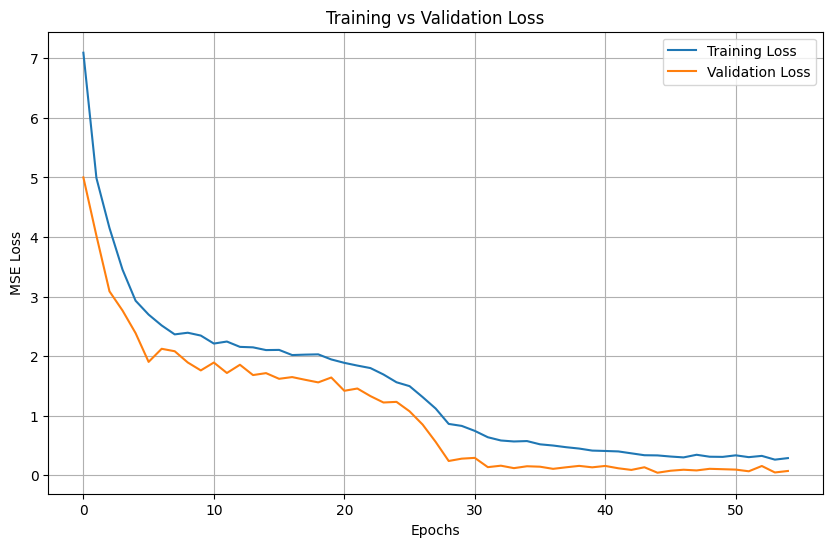

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.show()


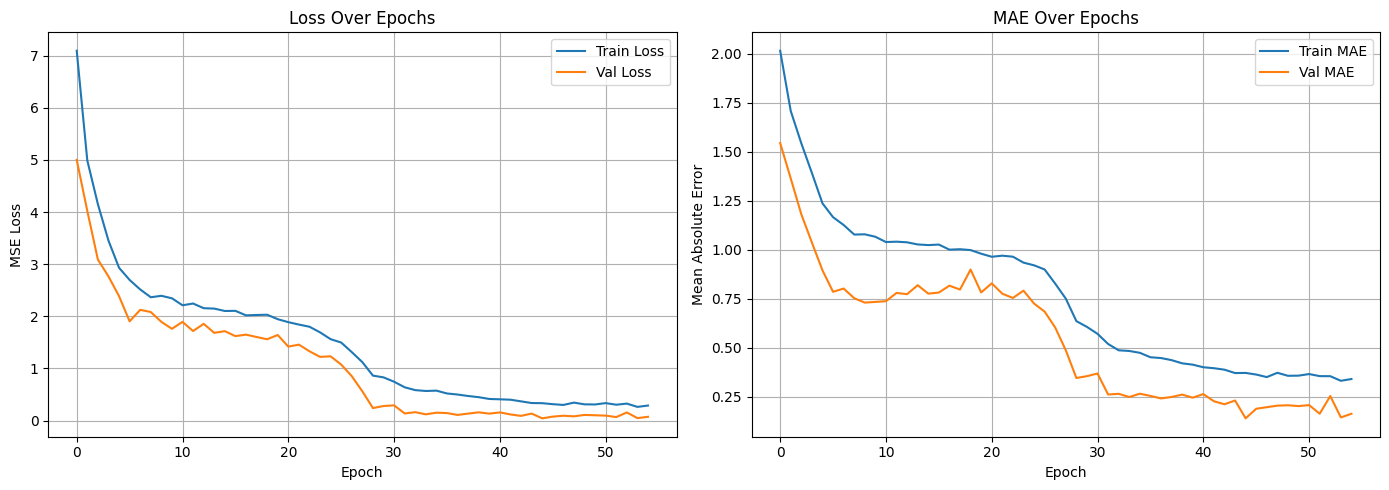

In [ ]:
# Plot loss and MAE
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Loss Plot
ax[0].plot(history.history['loss'], label='Train Loss')
ax[0].plot(history.history['val_loss'], label='Val Loss')
ax[0].set_title('Loss Over Epochs')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('MSE Loss')
ax[0].legend()
ax[0].grid(True)

# MAE Plot
ax[1].plot(history.history['mae'], label='Train MAE')
ax[1].plot(history.history['val_mae'], label='Val MAE')
ax[1].set_title('MAE Over Epochs')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Mean Absolute Error')
ax[1].legend()
ax[1].grid(True)

plt.tight_layout()
plt.show()


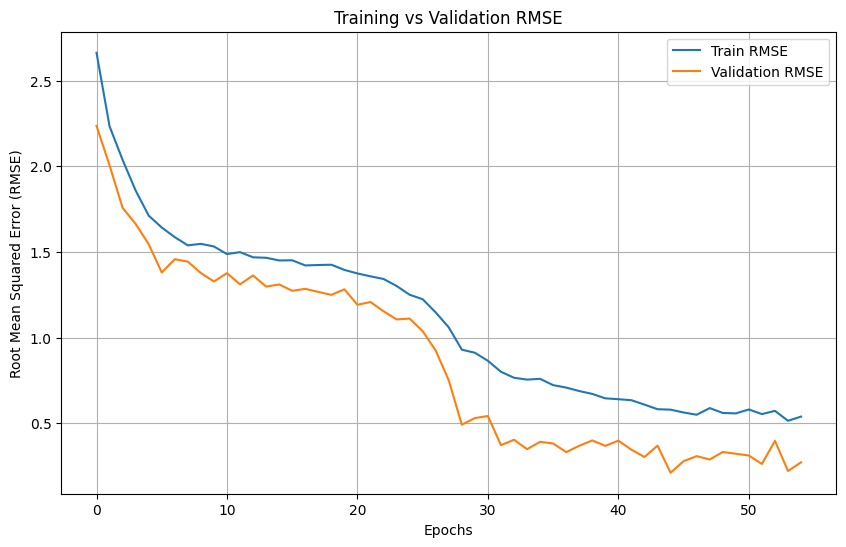

In [ ]:
# Calculate RMSE from MSE loss history
train_rmse = np.sqrt(history.history['loss'])
val_rmse = np.sqrt(history.history['val_loss'])

# Plot RMSE for training and validation
plt.figure(figsize=(10, 6))
plt.plot(train_rmse, label='Train RMSE')
plt.plot(val_rmse, label='Validation RMSE')
plt.title('Training vs Validation RMSE')
plt.xlabel('Epochs')
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
model.save("referral_model.h5")
print("✅ Model Training Complete!")

✅ Model Training Complete!


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.1/16.1 MB 85.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 56.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 73.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 68.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 81.0 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
  Attempting uninstall: ml_dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: tensorboard
    Found exis

In [ ]:
!pip install tensorflow==2.15.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.3/475.3 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 58.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 48.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 45.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 23.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 80.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 30.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 7.5 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.17.2
    Uninstalling wrapt-1.17.2:
      Successfully uninstalled wrapt-1.17.2
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.4
    Uninstalling protobuf-5.29.4:
      Successfully unin

In [ ]:
!pip3 install tensorflow_decision_forests==1.8.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 25.0 MB/s eta 0:00:00
  Attempting uninstall: tensorflow_decision_forests
    Found existing installation: tensorflow_decision_forests 1.12.0
    Uninstalling tensorflow_decision_forests-1.12.0:
      Successfully uninstalled tensorflow_decision_forests-1.12.0


In [ ]:
import tensorflowjs as tfjs

tfjs.converters.save_keras_model(model, "tfjs_model")